In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io

from scipy.misc import imread, imresize
from skimage.transform import resize
from tqdm import tqdm

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import Xception
from keras.models import Sequential, Model, load_model
from keras.layers import Activation, Dense, Multiply, Input, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam  
from keras import backend as K
import tensorflow as tf
from itertools import chain
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
name_label_dict = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

### Load dataset info:

In [3]:
path_to_train = '../input/train/'
data = pd.read_csv('../input/train.csv')

train_dataset_info = []
for name, labels in zip(data['Id'], data['Target'].str.split(' ')):
    train_dataset_info.append({
        'path':os.path.join(path_to_train, name),
        'labels':np.array([int(label) for label in labels])})
train_dataset_info = np.array(train_dataset_info)

### Create datagenerator

Our generator will return next structure: ([RGB_images, grayscale_images], labels). As described above, now we will have two inputs

In [4]:
class DataGenerator:
    def __init__(self, dataset_info, shape):
        self.image_generator = ImageDataGenerator(rescale=1. / 255,
                                     vertical_flip=True,
                                     horizontal_flip=True,
                                     rotation_range=180,
                                     fill_mode='reflect')
        self.cache = np.zeros((dataset_info.shape[0], shape[0], shape[1], shape[2]))
        self.is_cached = np.zeros((dataset_info.shape[0], 1))
    def create_train(self, dataset_info, batch_size, shape, augument=True, color = "red"):
        while True:
            random_indexes = np.random.choice(len(dataset_info), batch_size)
            batch_images1 = np.empty((batch_size, shape[0], shape[1], shape[2]))
            batch_labels = np.zeros((batch_size, 28))
            for i, idx in enumerate(random_indexes):
                if self.is_cached[idx] == 1:
                    image1 = self.cache[idx]
                else:
                    image1 = self.load_image(dataset_info[idx]['path'], shape, color)
                    self.cache[idx] = image1
                    self.is_cached[idx] = 1
                batch_images1[i] = image1
                batch_labels[i][dataset_info[idx]['labels']] = 1
            yield batch_images1, batch_labels
            
    
    def load_image(self, path, shape, color = "red"):
        image_ch = skimage.io.imread(path+ "_" + color+'.png')
        image1 = resize(image_ch, (shape[0], shape[1], 1), mode='reflect')
        return image1.astype(np.float)

### Show data:

In [5]:
# create train datagen
train_datagen = DataGenerator(train_dataset_info, (299,299,1))

generator = train_datagen.create_train(
    train_dataset_info, 5, (299,299,1))

### Split data
Split data into train and val part with a ratio 80/20, we will use for it "hack" from [this kernel](https://www.kaggle.com/kmader/rgb-transfer-learning-with-inceptionv3-for-protein)

In [6]:
# from https://www.kaggle.com/kmader/rgb-transfer-learning-with-inceptionv3-for-protein
data['target_list'] = data['Target'].map(lambda x: [int(a) for a in x.split(' ')])
all_labels = list(chain.from_iterable(data['target_list'].values))
c_val = Counter(all_labels)
n_keys = c_val.keys()
max_idx = max(n_keys)
data['target_vec'] = data['target_list'].map(lambda ck: [i in ck for i in range(max_idx+1)])
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(data, 
                 test_size = 0.2, 
                  # hack to make stratification work                  
                 stratify = data['Target'].map(lambda x: x[:3] if '27' not in x else '0'), random_state=42)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')
train_df.to_csv('train_part.csv')
valid_df.to_csv('valid_part.csv')




24857 training masks
6215 validation masks


### Create lists for training:

In [7]:
train_dataset_info = []
for name, labels in zip(train_df['Id'], train_df['Target'].str.split(' ')):
    train_dataset_info.append({
        'path':os.path.join(path_to_train, name),
        'labels':np.array([int(label) for label in labels])})
train_dataset_info = np.array(train_dataset_info)
valid_dataset_info = []
for name, labels in zip(valid_df['Id'], valid_df['Target'].str.split(' ')):
    valid_dataset_info.append({
        'path':os.path.join(path_to_train, name),
        'labels':np.array([int(label) for label in labels])})
valid_dataset_info = np.array(valid_dataset_info)
print(train_dataset_info.shape, valid_dataset_info.shape)

(24857,) (6215,)


In [8]:

def create_model(input_shape, n_out):
    inp_image = Input(shape=input_shape)
    x = BatchNormalization()(inp_image)
    x = Conv2D(16, kernel_size = (3,3), activation = "relu")(inp_image)
    x = MaxPooling2D(strides = (2,2))(x)
    x = Conv2D(32, kernel_size = (3,3), activation = "relu")(x)
    x = MaxPooling2D(strides = (2,2))(x)
    x = Conv2D(64, kernel_size = (3,3), activation = "relu")(x)
    x = MaxPooling2D(strides = (2,2))(x)
    x = Conv2D(128, kernel_size = (3,3), activation = "relu")(x)
    x = MaxPooling2D(strides = (2,2))(x)
    x = Conv2D(256, kernel_size = (3,3), activation = "relu")(x)
    x = MaxPooling2D(strides = (2,2))(x)
    x = Conv2D(256, kernel_size = (3,3), activation = "relu")(x)
    x = Flatten()(x)
    x = Dropout(.5)(x)
    x = Dense(100)(x)
    x = Dropout(.5)(x)
    out = Dense(n_out, activation='sigmoid')(x)
    model = Model(inputs=[inp_image], outputs=[out])

    return model

In [9]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [10]:

keras.backend.clear_session()
model = create_model(
    input_shape=(299,299,1), 
    n_out=28)

model.compile(
    loss='binary_crossentropy', 
    optimizer='adam',
    metrics=['acc', f1])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 299, 299, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 297, 297, 16)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 148, 148, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 146, 146, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 35, 35, 64)        0         
__________

In [11]:
epochs = 20; batch_size = 12
valid_dataset_info.shape

(6215,)

In [13]:
history = {}
colors = ["green", "red", "blue", "yellow"]
for color in colors:
    checkpointer = ModelCheckpoint('../working/' + color + '.model', verbose=2, save_best_only=True)
    model = create_model(
    input_shape=(299,299,1), 
    n_out=28)

    model.compile(
        loss='binary_crossentropy', 
        optimizer='adam',
        metrics=['acc', f1])

    model.summary()
    train_datagen = DataGenerator(train_dataset_info, (299,299,1))
    valid_datagen = DataGenerator(valid_dataset_info, (299,299,1))
    train_generator = train_datagen.create_train(
        train_dataset_info, batch_size, (299,299,1), color = color)
    validation_generator = valid_datagen.create_train(
        valid_dataset_info, batch_size, (299,299,1), color = color)
    # train model
    history[color] = model.fit_generator(
        train_generator,
        steps_per_epoch=(len(train_df)//batch_size),
        validation_data=validation_generator,
        validation_steps=(len(valid_df)//batch_size),
        epochs=epochs, 
        verbose=2,
        callbacks=[checkpointer])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 299, 299, 1)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 297, 297, 16)      160       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 148, 148, 16)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 146, 146, 32)      4640      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 35, 35, 64)        0         
__________


Epoch 00008: val_loss did not improve from 0.17321
Epoch 9/20
 - 60s - loss: 0.1762 - acc: 0.9417 - f1: 0.0000e+00 - val_loss: 0.1718 - val_acc: 0.9422 - val_f1: 0.0000e+00

Epoch 00009: val_loss improved from 0.17321 to 0.17177, saving model to ../working/blue.model
Epoch 10/20
 - 60s - loss: 0.1760 - acc: 0.9413 - f1: 0.0000e+00 - val_loss: 0.1735 - val_acc: 0.9417 - val_f1: 0.0000e+00

Epoch 00010: val_loss did not improve from 0.17177
Epoch 11/20
 - 60s - loss: 0.1757 - acc: 0.9417 - f1: 0.0000e+00 - val_loss: 0.1733 - val_acc: 0.9419 - val_f1: 0.0000e+00

Epoch 00011: val_loss did not improve from 0.17177
Epoch 12/20
 - 60s - loss: 0.1761 - acc: 0.9415 - f1: 0.0000e+00 - val_loss: 0.1747 - val_acc: 0.9417 - val_f1: 0.0000e+00

Epoch 00012: val_loss did not improve from 0.17177
Epoch 13/20
 - 60s - loss: 0.1752 - acc: 0.9417 - f1: 0.0000e+00 - val_loss: 0.1737 - val_acc: 0.9420 - val_f1: 0.0000e+00

Epoch 00013: val_loss did not improve from 0.17177
Epoch 14/20
 - 60s - loss: 0.17

### Visualize history
There are a few epochs only, but in full variant it will be useful:

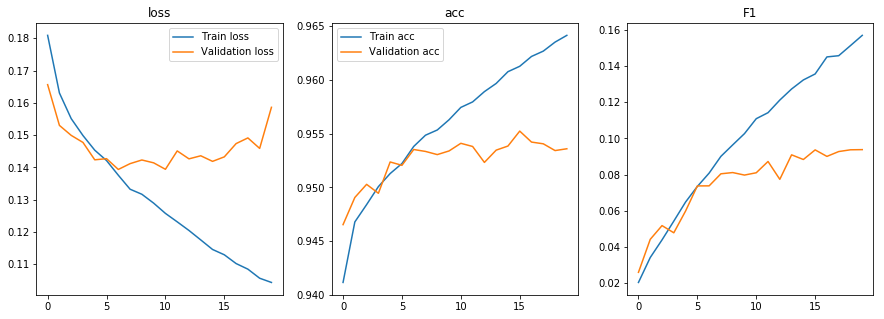

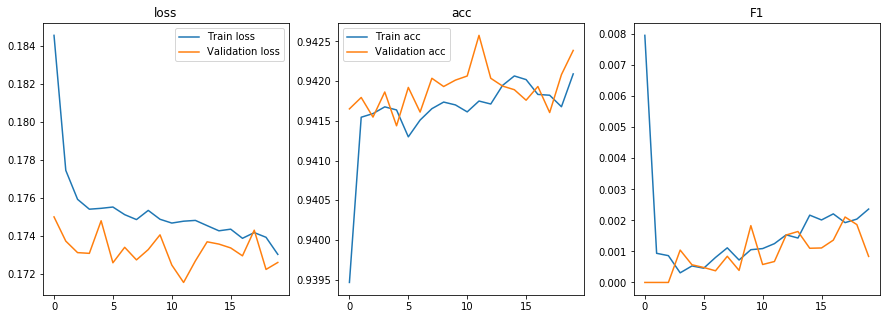

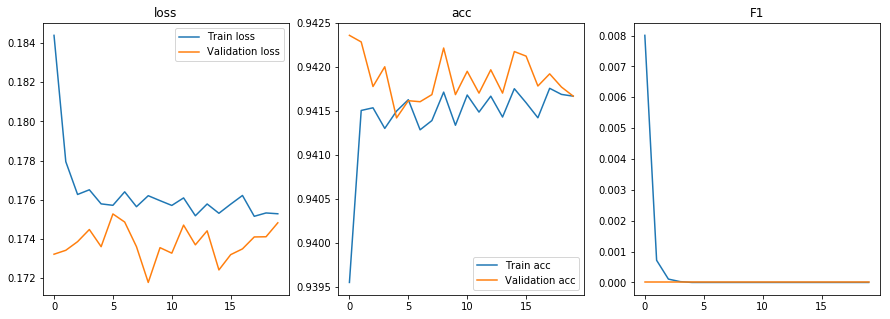

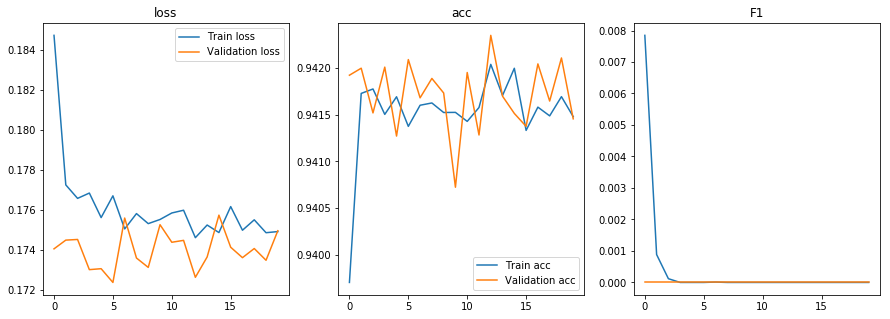

In [14]:
for color in colors:
    history1 = history[color]
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history1.epoch, history1.history["loss"], label="Train loss")
    ax[0].plot(history1.epoch, history1.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history1.epoch, history1.history["acc"], label="Train acc")
    ax[1].plot(history1.epoch, history1.history["val_acc"], label="Validation acc")
    ax[2].set_title('F1')
    ax[2].plot(history1.epoch, history1.history["f1"], label="Train F1")
    ax[2].plot(history1.epoch, history1.history["val_f1"], label="Validation F1")
    ax[0].legend()
    _ = ax[1].legend()

### Classes distribution:

In [15]:
%%time
%matplotlib inline
from tqdm import tqdm_notebook
train_sum_vec = {}
for color in colors:
    print("=========")
    print(color)
    print("=========")
    predicted = [] 
    model.load_weights(filepath = ('../working/' + color + '.model'))
    pred_df = pd.DataFrame()
    for name in tqdm(valid_df['Id']):
        path = os.path.join('../input/train/', name)
        image1 = train_datagen.load_image(path, (299,299,1))
        score_predict = model.predict(image1[np.newaxis])[0]
        label_predict = np.arange(28)[score_predict>=0.01]
        str_predict_label = ' '.join(str(l) for l in label_predict)
        predicted.append(str_predict_label)
    pred_df['Predicted'] = predicted
    pred_df['target_list'] = pred_df['Predicted'].map(lambda x: [int(a) for a in str(x).split(' ')])
    pred_df['target_vec'] = pred_df['target_list'].map(lambda ck: [i in ck for i in range(max_idx+1)])
    
    train_sum_vec[color] = np.sum(np.stack(pred_df['target_vec'].values, 0), 0)


green


100%|██████████████████████████████████████████████████████████████████████████████| 6215/6215 [01:28<00:00, 70.62it/s]


red


100%|██████████████████████████████████████████████████████████████████████████████| 6215/6215 [01:27<00:00, 71.25it/s]


blue


100%|██████████████████████████████████████████████████████████████████████████████| 6215/6215 [01:27<00:00, 71.11it/s]


yellow


100%|██████████████████████████████████████████████████████████████████████████████| 6215/6215 [01:27<00:00, 71.26it/s]


Wall time: 5min 50s


In [16]:
for i, color in enumerate(colors):
    history1 = history[color].history
    print(color + " loss: " , np.min(history1["loss"]))
    print(color + " val loss: " , np.min(history1["val_loss"]))
    print(color + " acc: " , np.max(history1["acc"]))
    print(color + " val_acc: " , np.max(history1["val_acc"]))
    print(color + " f1: " , np.max(history1["f1"]))
    print(color + " val_f1: " , np.max(history1["val_f1"]))

green loss:  0.10433298303331516
green val loss:  0.13934955621999284
green acc:  0.9641175719345899
green val_acc:  0.9552247279847844
green f1:  0.15691610536156272
green val_f1:  0.09379951455729439
red loss:  0.173019514531113
red val loss:  0.17153864201136668
red acc:  0.942091453081165
red val_acc:  0.9425773543361539
red f1:  0.007959013344753284
red val_f1:  0.0021080468849745547
blue loss:  0.1751503642704221
blue val loss:  0.17177008249485284
blue acc:  0.9417566136137291
blue val_acc:  0.9423586007935397
blue f1:  0.00800614848684381
blue val_f1:  0.0
yellow loss:  0.17461663415859657
yellow val loss:  0.17237583660237793
yellow acc:  0.9420368432825974
yellow val_acc:  0.9423470869516266
yellow f1:  0.007846258846230766
yellow val_f1:  0.0


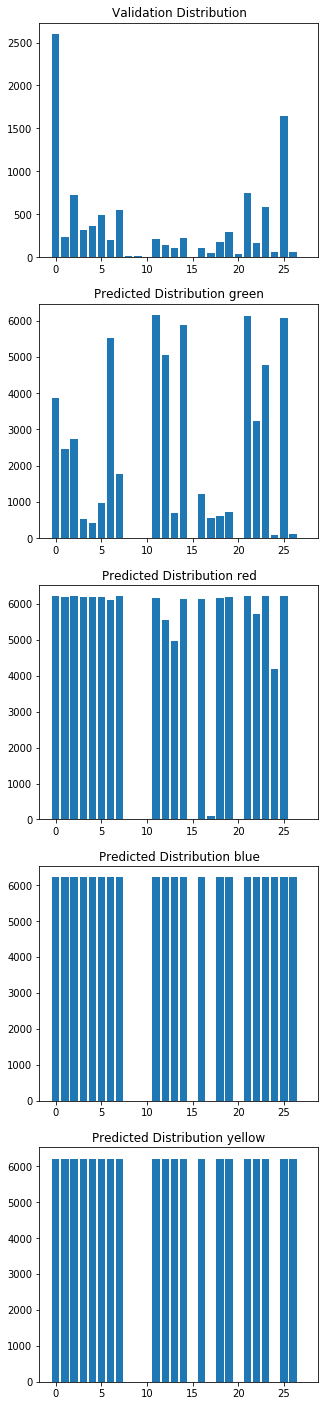

In [17]:
fig, ax = plt.subplots(5, 1, figsize = (5, 25))
valid_sum_vec = np.sum(np.stack(valid_df['target_vec'].values, 0), 0)
ax[0].bar(n_keys, [valid_sum_vec[k] for k in n_keys])
_ = ax[0].set_title('Validation Distribution')
for i, color in enumerate(colors):
    ax[i+1].bar(n_keys, [train_sum_vec[color][k] for k in n_keys])
    ax[i+1].set_title('Predicted Distribution ' + color)
    

